##**Loading Libraries & Data**

In [1]:
from google.colab import files
import os
import random
from shutil import copyfile

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Unzipping training data
from zipfile import ZipFile
file_name = "/content/drive/MyDrive/Artificial Neurons.AI/Healthcare-images-classification-20221006T055456Z-001.zip"
with ZipFile(file_name, 'r') as zip:
  zip.extractall()
  print('done')

done


In [4]:
import warnings
warnings.filterwarnings('ignore')
# Get all the paths
data_dir_list = os.listdir('/content/Healthcare-images-classification')
print(data_dir_list)
path, dirs, files = next(os.walk("/content/Healthcare-images-classification"))
file_count = len(files)
# print(file_count)

['X-Ray', 'ECG', 'Presciption', 'Report']


In [5]:
# Making new base directory
original_dataset_dir = '/content/Healthcare-images-classification'
base_dir = '/content/healthcare-data/'
os.mkdir(base_dir)

In [6]:
#creating two folders (train and validation)
train_dir = os.path.join(base_dir, 'train')
os.mkdir(train_dir)

validation_dir = os.path.join(base_dir, 'validation')
os.mkdir(validation_dir)

#Under train folder creating four folders 
# (ECG, Prescription, Report, X-Ray)

train_ecg_dir = os.path.join(train_dir, 'ECG')
os.mkdir(train_ecg_dir)

train_prescription_dir = os.path.join(train_dir, 'Prescription')
os.mkdir(train_prescription_dir)

train_report_dir = os.path.join(train_dir, 'Report')
os.mkdir(train_report_dir)

train_xray_dir = os.path.join(train_dir, 'X-Ray')
os.mkdir(train_xray_dir)

#Under validation folder creating four folders 
# (ECG, Prescription, Report, X-Ray)

validation_ecg_dir = os.path.join(validation_dir, 'ECG')
os.mkdir(validation_ecg_dir)

validation_prescription_dir = os.path.join(validation_dir, 'Prescription')
os.mkdir(validation_prescription_dir)

validation_report_dir = os.path.join(validation_dir, 'Report')
os.mkdir(validation_report_dir)

validation_xray_dir = os.path.join(validation_dir, 'X-Ray')
os.mkdir(validation_xray_dir)


In [7]:
#Function to split images
def split_data(SOURCE, TRAINING, VALIDATION, SPLIT_SIZE):
    files = []
    for filename in os.listdir(SOURCE):
        file = SOURCE + filename
        if os.path.getsize(file) > 0:
            files.append(filename)
        else:
            print(filename + " is zero length, so ignoring.")

    training_length = int(len(files) * SPLIT_SIZE)
    valid_length = int(len(files) - training_length)
    shuffled_set = random.sample(files, len(files))
    training_set = shuffled_set[0:training_length]
    valid_set = shuffled_set[training_length:]

    for filename in training_set:
        this_file = SOURCE + filename
        destination = TRAINING + filename
        copyfile(this_file, destination)

    for filename in valid_set:
        this_file = SOURCE + filename
        destination = VALIDATION + filename
        copyfile(this_file, destination)

In [8]:
ECG_SOURCE_DIR = '/content/Healthcare-images-classification/ECG/'
TRAINING_ECG_DIR = '/content/healthcare-data/train/ECG/'
VALID_ECG_DIR = '/content/healthcare-data/validation/ECG/'

PRESCRIPTION_SOURCE_DIR = '/content/Healthcare-images-classification/Presciption/'
TRAINING_PRESCRIPTION_DIR = '/content/healthcare-data/train/Prescription/'
VALID_PRESCRIPTION_DIR = '/content/healthcare-data/validation/Prescription/'

REPORT_SOURCE_DIR = '/content/Healthcare-images-classification/Report/'
TRAINING_REPORT_DIR = '/content/healthcare-data/train/Report/'
VALID_REPORT_DIR = '/content/healthcare-data/validation/Report/'

XRAY_SOURCE_DIR = '/content/Healthcare-images-classification/X-Ray/'
TRAINING_XRAY_DIR = '/content/healthcare-data/train/X-Ray/'
VALID_XRAY_DIR = '/content/healthcare-data/validation/X-Ray/'


In [9]:
split_size = .80

split_data(ECG_SOURCE_DIR, TRAINING_ECG_DIR, VALID_ECG_DIR, split_size)
split_data(PRESCRIPTION_SOURCE_DIR, TRAINING_PRESCRIPTION_DIR, VALID_PRESCRIPTION_DIR, split_size)
split_data(REPORT_SOURCE_DIR, TRAINING_REPORT_DIR, VALID_REPORT_DIR, split_size)
split_data(XRAY_SOURCE_DIR, TRAINING_XRAY_DIR, VALID_XRAY_DIR, split_size)

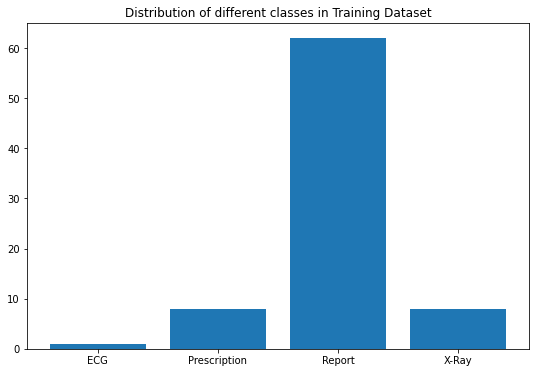

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.image import imread
import pathlib

image_folder = ['ECG', 'Prescription', 'Report', 'X-Ray']
nimgs = {}
for i in image_folder:
    nimages = len(os.listdir('/content/healthcare-data/train/'+i+'/'))
    nimgs[i]=nimages
plt.figure(figsize=(9, 6))
plt.bar(range(len(nimgs)), list(nimgs.values()), align='center')
plt.xticks(range(len(nimgs)), list(nimgs.keys()))
plt.title('Distribution of different classes in Training Dataset')
plt.show()

In [11]:
for i in ['ECG', 'Prescription', 'Report', 'X-Ray']:
    print('Training {} images are: '.format(i)+str(len(os.listdir('/content/healthcare-data/train/'+i+'/'))))

Training ECG images are: 1
Training Prescription images are: 8
Training Report images are: 62
Training X-Ray images are: 8


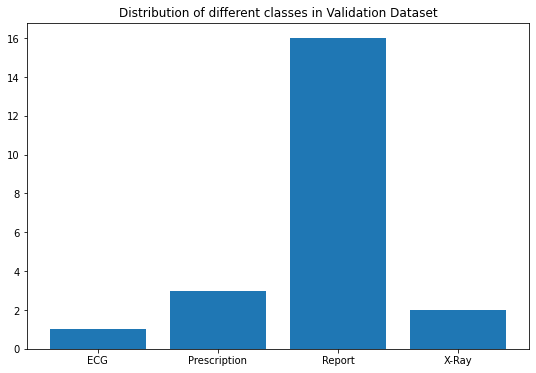

In [12]:
image_folder = ['ECG', 'Prescription', 'Report', 'X-Ray']
nimgs = {}
for i in image_folder:
    nimages = len(os.listdir('/content/healthcare-data/validation/'+i+'/'))
    nimgs[i]=nimages
plt.figure(figsize=(9, 6))
plt.bar(range(len(nimgs)), list(nimgs.values()), align='center')
plt.xticks(range(len(nimgs)), list(nimgs.keys()))
plt.title('Distribution of different classes in Validation Dataset')
plt.show()

In [13]:
for i in ['ECG', 'Prescription', 'Report', 'X-Ray']:
    print('Valid {} images are: '.format(i)+str(len(os.listdir('/content/healthcare-data/validation/'+i+'/'))))

Valid ECG images are: 1
Valid Prescription images are: 3
Valid Report images are: 16
Valid X-Ray images are: 2


##**Data Augmentation**

In [14]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [15]:
img_width=256; img_height=256
batch_size=16

In [16]:
TRAINING_DIR = '/content/healthcare-data/train/'

train_datagen = ImageDataGenerator(rescale = 1/255.0,
                                   rotation_range=30,
                                   zoom_range=0.4,
                                   horizontal_flip=True)

train_generator = train_datagen.flow_from_directory(TRAINING_DIR,
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    target_size=(img_height, img_width))

Found 79 images belonging to 4 classes.


In [17]:
VALIDATION_DIR = '/content/healthcare-data/validation/'

validation_datagen = ImageDataGenerator(rescale = 1/255.0)

validation_generator = validation_datagen.flow_from_directory(VALIDATION_DIR,
                                                              batch_size=batch_size,
                                                              class_mode='categorical',
                                                              target_size=(img_height, img_width)
                                                             )

Found 22 images belonging to 4 classes.


##**CNN Model**

In [18]:
callbacks = EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='auto')
# autosave best Model
best_model_file = '/content/CNN_aug_best_weights.h5'
best_model = ModelCheckpoint(best_model_file, monitor='val_acc', verbose = 1, save_best_only = True)

In [19]:
model = Sequential([
    Conv2D(16, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)), MaxPooling2D(2, 2),
    Conv2D(32, (3, 3), activation='relu'), MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(256, (3, 3), activation='relu'),
    Conv2D(256, (3, 3), activation='relu'),
    Conv2D(256, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(512, activation='relu'),
    Dense(4, activation='softmax')
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 58, 58, 64)        3

In [20]:
model.compile(optimizer='Adam', 
              loss='categorical_crossentropy', 
              metrics =['accuracy'])

In [21]:
history = model.fit_generator(train_generator,
                              epochs=30,
                              verbose=1,
                              validation_data=validation_generator,
                              callbacks = [best_model]
                              )

Epoch 1/30
5/5 [==============================] - ETA: 0s - loss: 1.4166 - accuracy: 0.7848

5/5 [==============================] - 13s 762ms/step - loss: 1.4166 - accuracy: 0.7848 - val_loss: 1.2823 - val_accuracy: 0.7273
Epoch 2/30
5/5 [==============================] - ETA: 0s - loss: 1.2641 - accuracy: 0.7848

5/5 [==============================] - 3s 557ms/step - loss: 1.2641 - accuracy: 0.7848 - val_loss: 1.1583 - val_accuracy: 0.7273
Epoch 3/30
5/5 [==============================] - ETA: 0s - loss: 0.9327 - accuracy: 0.7848

5/5 [==============================] - 3s 565ms/step - loss: 0.9327 - accuracy: 0.7848 - val_loss: 1.0447 - val_accuracy: 0.7273
Epoch 4/30
5/5 [==============================] - ETA: 0s - loss: 0.6826 - accuracy: 0.7848

5/5 [==============================] - 3s 566ms/step - loss: 0.6826 - accuracy: 0.7848 - val_loss: 0.8482 - val_accuracy: 0.7273
Epoch 5/30
5/5 [==============================] - ETA: 0s - loss: 0.7203 - accuracy: 0.7848

5/5 [==============================] - 3s 594ms/step - loss: 0.7203 - accuracy: 0.7848 - val_loss: 0.8933 - val_accuracy: 0.7273
Epoch 6/30
5/5 [==============================] - ETA: 0s - loss: 0.7067 - accuracy: 0.7848

5/5 [==============================] - 4s 764ms/step - loss: 0.7067 - accuracy: 0.7848 - val_loss: 0.8579 - val_accuracy: 0.7273
Epoch 7/30
5/5 [==============================] - ETA: 0s - loss: 0.7117 - accuracy: 0.7848

5/5 [==============================] - 3s 555ms/step - loss: 0.7117 - accuracy: 0.7848 - val_loss: 0.9375 - val_accuracy: 0.7273
Epoch 8/30
5/5 [==============================] - ETA: 0s - loss: 0.7619 - accuracy: 0.7848

5/5 [==============================] - 3s 563ms/step - loss: 0.7619 - accuracy: 0.7848 - val_loss: 0.8492 - val_accuracy: 0.7273
Epoch 9/30
5/5 [==============================] - ETA: 0s - loss: 0.7309 - accuracy: 0.7848

5/5 [==============================] - 3s 557ms/step - loss: 0.7309 - accuracy: 0.7848 - val_loss: 0.8636 - val_accuracy: 0.7273
Epoch 10/30
5/5 [==============================] - ETA: 0s - loss: 0.6763 - accuracy: 0.7848

5/5 [==============================] - 3s 549ms/step - loss: 0.6763 - accuracy: 0.7848 - val_loss: 0.8977 - val_accuracy: 0.7273
Epoch 11/30
5/5 [==============================] - ETA: 0s - loss: 0.7380 - accuracy: 0.7848

5/5 [==============================] - 3s 560ms/step - loss: 0.7380 - accuracy: 0.7848 - val_loss: 1.0926 - val_accuracy: 0.7273
Epoch 12/30
5/5 [==============================] - ETA: 0s - loss: 0.7117 - accuracy: 0.8101

5/5 [==============================] - 3s 554ms/step - loss: 0.7117 - accuracy: 0.8101 - val_loss: 0.8644 - val_accuracy: 0.7727
Epoch 13/30
5/5 [==============================] - ETA: 0s - loss: 0.5419 - accuracy: 0.8608

5/5 [==============================] - 3s 566ms/step - loss: 0.5419 - accuracy: 0.8608 - val_loss: 0.9222 - val_accuracy: 0.7273
Epoch 14/30
5/5 [==============================] - ETA: 0s - loss: 0.6784 - accuracy: 0.8228

5/5 [==============================] - 3s 552ms/step - loss: 0.6784 - accuracy: 0.8228 - val_loss: 0.9857 - val_accuracy: 0.7273
Epoch 15/30
5/5 [==============================] - ETA: 0s - loss: 0.6006 - accuracy: 0.8354

5/5 [==============================] - 3s 550ms/step - loss: 0.6006 - accuracy: 0.8354 - val_loss: 0.6885 - val_accuracy: 0.8182
Epoch 16/30
5/5 [==============================] - ETA: 0s - loss: 0.4823 - accuracy: 0.8608

5/5 [==============================] - 3s 566ms/step - loss: 0.4823 - accuracy: 0.8608 - val_loss: 0.7099 - val_accuracy: 0.8182
Epoch 17/30
5/5 [==============================] - ETA: 0s - loss: 0.6088 - accuracy: 0.8481

5/5 [==============================] - 3s 564ms/step - loss: 0.6088 - accuracy: 0.8481 - val_loss: 0.6962 - val_accuracy: 0.8182
Epoch 18/30
5/5 [==============================] - ETA: 0s - loss: 0.4945 - accuracy: 0.8734

5/5 [==============================] - 3s 550ms/step - loss: 0.4945 - accuracy: 0.8734 - val_loss: 0.6586 - val_accuracy: 0.8182
Epoch 19/30
5/5 [==============================] - ETA: 0s - loss: 0.4619 - accuracy: 0.8734

5/5 [==============================] - 3s 550ms/step - loss: 0.4619 - accuracy: 0.8734 - val_loss: 0.6906 - val_accuracy: 0.8182
Epoch 20/30
5/5 [==============================] - ETA: 0s - loss: 0.3952 - accuracy: 0.8861

5/5 [==============================] - 3s 550ms/step - loss: 0.3952 - accuracy: 0.8861 - val_loss: 0.8456 - val_accuracy: 0.8182
Epoch 21/30
5/5 [==============================] - ETA: 0s - loss: 0.4545 - accuracy: 0.8608

5/5 [==============================] - 3s 552ms/step - loss: 0.4545 - accuracy: 0.8608 - val_loss: 0.8056 - val_accuracy: 0.8182
Epoch 22/30
5/5 [==============================] - ETA: 0s - loss: 0.4073 - accuracy: 0.8861

5/5 [==============================] - 3s 560ms/step - loss: 0.4073 - accuracy: 0.8861 - val_loss: 0.6336 - val_accuracy: 0.8182
Epoch 23/30
5/5 [==============================] - ETA: 0s - loss: 0.4126 - accuracy: 0.8734

5/5 [==============================] - 3s 559ms/step - loss: 0.4126 - accuracy: 0.8734 - val_loss: 1.4992 - val_accuracy: 0.6818
Epoch 24/30
5/5 [==============================] - ETA: 0s - loss: 0.5570 - accuracy: 0.8481

5/5 [==============================] - 3s 567ms/step - loss: 0.5570 - accuracy: 0.8481 - val_loss: 1.0670 - val_accuracy: 0.7273
Epoch 25/30
5/5 [==============================] - ETA: 0s - loss: 0.6879 - accuracy: 0.7975

5/5 [==============================] - 3s 562ms/step - loss: 0.6879 - accuracy: 0.7975 - val_loss: 0.8971 - val_accuracy: 0.7273
Epoch 26/30
5/5 [==============================] - ETA: 0s - loss: 0.6168 - accuracy: 0.8481

5/5 [==============================] - 3s 558ms/step - loss: 0.6168 - accuracy: 0.8481 - val_loss: 0.6324 - val_accuracy: 0.8182
Epoch 27/30
5/5 [==============================] - ETA: 0s - loss: 0.5411 - accuracy: 0.8481

5/5 [==============================] - 3s 552ms/step - loss: 0.5411 - accuracy: 0.8481 - val_loss: 0.7128 - val_accuracy: 0.8182
Epoch 28/30
5/5 [==============================] - ETA: 0s - loss: 0.4771 - accuracy: 0.8734

5/5 [==============================] - 3s 547ms/step - loss: 0.4771 - accuracy: 0.8734 - val_loss: 2.3555 - val_accuracy: 0.3636
Epoch 29/30
5/5 [==============================] - ETA: 0s - loss: 0.7192 - accuracy: 0.7722

5/5 [==============================] - 3s 548ms/step - loss: 0.7192 - accuracy: 0.7722 - val_loss: 0.8764 - val_accuracy: 0.7273
Epoch 30/30
5/5 [==============================] - ETA: 0s - loss: 0.6846 - accuracy: 0.7848

5/5 [==============================] - 3s 561ms/step - loss: 0.6846 - accuracy: 0.7848 - val_loss: 0.8458 - val_accuracy: 0.7273


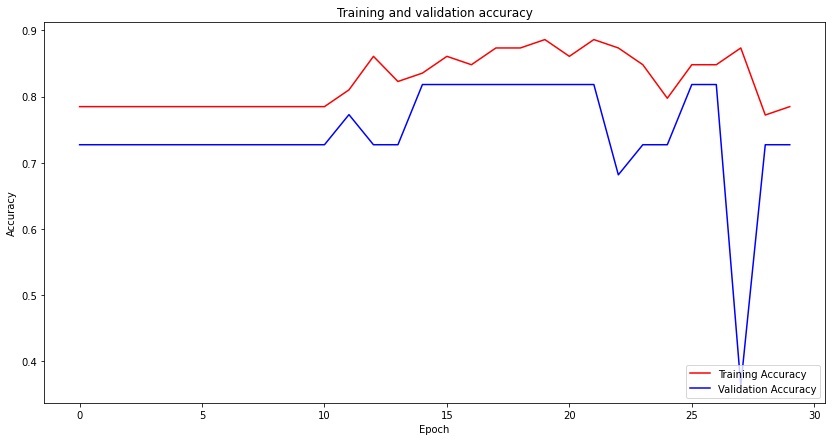

In [22]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc))

fig = plt.figure(figsize=(14,7))
plt.plot(epochs, acc, 'r', label="Training Accuracy")
plt.plot(epochs, val_acc, 'b', label="Validation Accuracy")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc='lower right')
plt.show()

Text(0.5, 1.0, 'Training and validation loss')

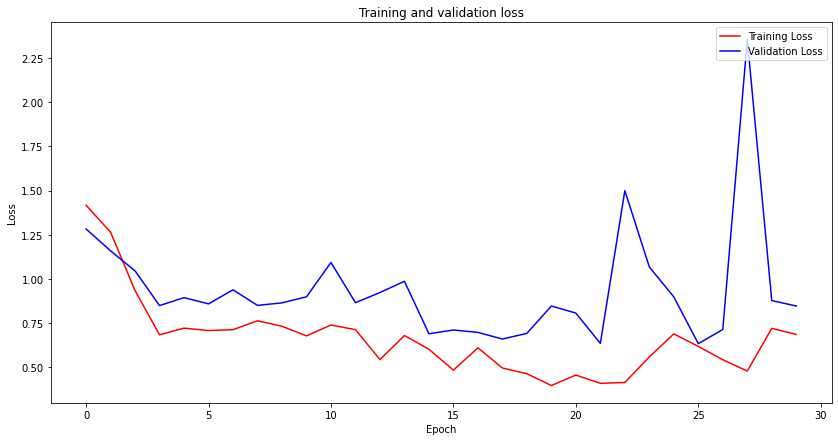

In [23]:
fig2 = plt.figure(figsize=(14,7))
plt.plot(epochs, loss, 'r', label="Training Loss")
plt.plot(epochs, val_loss, 'b', label="Validation Loss")
plt.legend(loc='upper right')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and validation loss')

**This CNN Model Accuracy Score is 0.886**